In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline

In [ ]:
def f(x):
    return 3*x**2 - 4*x +5

In [ ]:
f(3.0)

20.0

In [ ]:
xs=np.arange(-5,5,0.25)
xs

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

In [ ]:
ys=f(xs)
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

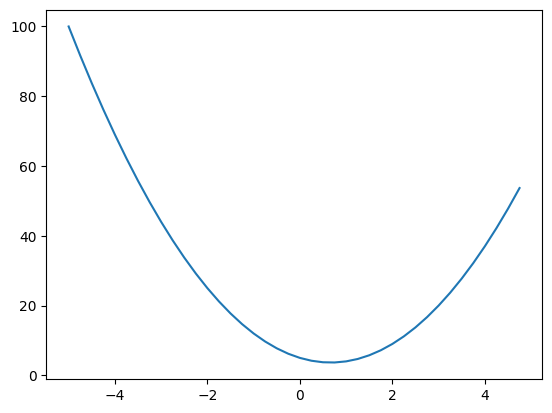

In [ ]:
plt.plot(xs,ys)

In [ ]:
h=0.00000000000001
x=3.0
f(x+h)

20.000000000000142

In [ ]:
slope=(f(x+h)- f(x))/h
slope

14.210854715202004

In [ ]:
a=2.0
b= -3.0
c=10
d=a*b+c
d

4.0

In [ ]:
h=0.00000000000001

a=2.0
b= -3.0
c=10

d1=a*b+c
a+=h

d2=a*b+c

print('d1',d1)
print('d2',d2)
print('slope',((d2-d1)/h))

d1 4.0
d2 3.99999999999997
slope -3.019806626980426


In [ ]:
class Value:
  def __init__(self,data, _children=(),_op='',label=''): #_children=() is a tuple
    self.data=data
    self.grad=0.0
    self._backward = lambda:None
    self._prev=set(_children)
    self._op=_op  #why _op - cos its only for internal use, if just op then everyone , outsiders also can use
    self.label=label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self,other):
    other = other if isinstance(other,Value) else Value(other)  # to uniforml;y have all as Value type
    out=Value(self.data + other.data, (self,other), '+') #to list the ingredient children

    def _backward():
      self.grad += 1.0* out.grad
      other.grad += 1.0* out.grad
    out._backward=_backward

    return out

  def __mul__(self,other):
    other = other if isinstance(other,Value) else Value(other)  # to uniforml;y have all as Value type
    out=Value(self.data * other.data, (self,other), '*')

    def _backward():
      self.grad += other.data* out.grad
      other.grad += self.data* out.grad
    out._backward=_backward
    return out

  def __pow__(self,other):
    assert isinstance(other, (int,float)), "only supporting int and float powers for now"
    out=Value(self.data ** other, (self,), f'**{other}')

    def _backward():
      self.grad += other* (self.data ** (other -1))* out.grad
    out._backward=_backward
    return out



  def __rmul__(self,other):
    return self*other

  def __truediv__(self,other):
    return self*other**-1

  def __neg__(self):
    return self*-1
  def __sub__(self,other):
    return self + (-other)



  def tanh(self):
    x=self.data
    t=(math.exp(2*x)-1)/(math.exp(2*x)+1)
    out=Value(t, (self,), 'tanh')

    def _backward():
      self.grad += (1-t**2)* out.grad
    out._backward=_backward
    return out

  def exp(self):
    x=self.data
    out=Value(math.exp(x), (self,), 'exp')

    def _backward():
      self.grad += out.data * out.grad # dy/dx of e^x is e^x and out.grad as chain rule
    out._backward=_backward
    return out

  def backward(self):
    topo=[]
    visited=set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad=1.0
    for node in reversed(topo):
      node._backward()





a=Value(2.0, label='a')
b=Value(-3.0, label='b')
c=Value(10.0, label='c')
e=a*b; e.label='e'
d=e+c; d.label='d'
f=Value(-2.0, label='f')
L=d*f; L.label='L' #python internally calls a.__add__(b), self=a
L

Value(data=-8.0)

In [ ]:
a=Value(math.e)
b=Value(math.e)
a-b

Value(data=0.0)

In [ ]:
a=Value(math.e)
a*11

Value(data=29.901100113049495)

In [ ]:
2*a #works thanks to rmul (reverse mult)

Value(data=5.43656365691809)

In [ ]:
a.exp()

Value(data=15.154262241479262)

In [ ]:
d._prev


{Value(data=-6.0), Value(data=10.0)}

In [ ]:
d._op

'+'

In [ ]:
from graphviz import Digraph
def trace(root):
  nodes,edges=set(),set()

  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child,v))
        build(child)
  build(root)
  return nodes,edges


def draw_dot(root):
  dot=Digraph(format='svg',graph_attr={'rankdir':'LR'}) #LR- LEFT TO RIGHT

  nodes,edges=trace(root)
  for n in nodes:
    uid=str(id(n))

    dot.node(name=uid, label="{ %s | data %.4f | grad %.4f}" % (n.label,n.data,n.grad), shape="record")

    if n._op:
      dot.node(name=uid + n._op,label=n._op)

      dot.edge(uid + n._op,uid)

  for n1,n2 in edges:
    dot.edge(str(id(n1)),str(id(n2)) + n2._op )

  return dot


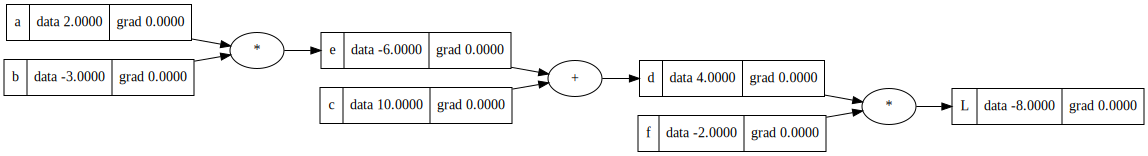

In [ ]:
draw_dot(L) #VISUALISATION OF FWD PASS, L SIGNIFIES A REALLY SIMPLIFIED LOSS FUNCTION

In [ ]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e=a*b
d=e+c
L=d*f

print(L.data)


-34.7781121978613


In [ ]:
a.grad=-2.0 * -3.0
b.grad=-2.0 * 2.0

In [ ]:
c.grad=-2.0
e.grad=-2.0

In [ ]:
L.grad = 1.0

In [ ]:
f.grad=4.0
d.grad=-2.0

In [ ]:
def lol():

  H=0.0001
  a=Value(2.0, label='a')
  b=Value(-3.0, label='b')
  c=Value(10.0, label='c')
  e=a*b; e.label='e'
  d=e+c; d.label='d'
  f=Value(-2.0, label='f')
  L=d*f; L.label='L'
  L1=L.data

  a=Value(2.0 + h, label='a')
  b=Value(-3.0, label='b')
  c=Value(10.0, label='c')
  e=a*b; e.label='e'
  d=e+c; d.label='d'
  f=Value(-2.0, label='f')
  L=d*f; L.label='L'
  L2=L.data

  print((L2 - L1)/h)

lol()

6.039613253960852


In [ ]:
#inputs
x1=Value(2.0, label='x1')
x2=Value(0.0, label='x2')

#wts
w1=Value(-3.0, label='w1')
w2=Value(1.0, label='w2')

#bias
b=Value(6.8813, label='b')

x1w1=x1*w1;x1w1.label='x1w1'
x2w2=x2*w2;x2w2.label='x2w2'

x1w1x2w2=x1w1 + x2w2; x1w1x2w2.label='x1w1 + x2w2'
n=x1w1x2w2 + b; n.label='n'


o=n.tanh(); o.label='o'

o.backward()

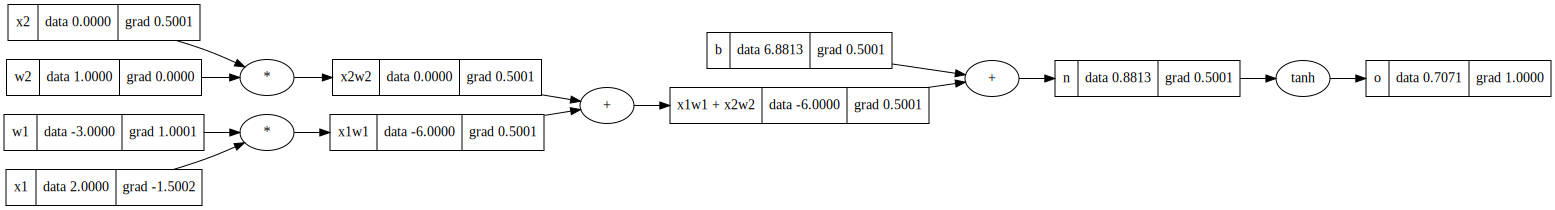

In [ ]:
draw_dot(o)

In [ ]:
#inputs
x1=Value(2.0, label='x1')
x2=Value(0.0, label='x2')

#wts
w1=Value(-3.0, label='w1')
w2=Value(1.0, label='w2')

#bias
b=Value(6.8813, label='b')

x1w1=x1*w1;x1w1.label='x1w1'
x2w2=x2*w2;x2w2.label='x2w2'

x1w1x2w2=x1w1 + x2w2; x1w1x2w2.label='x1w1 + x2w2'
n=x1w1x2w2 + b; n.label='n'


e= (2*n).exp()
o= (e-1)/(e+1)


o.label='o'

o.backward()

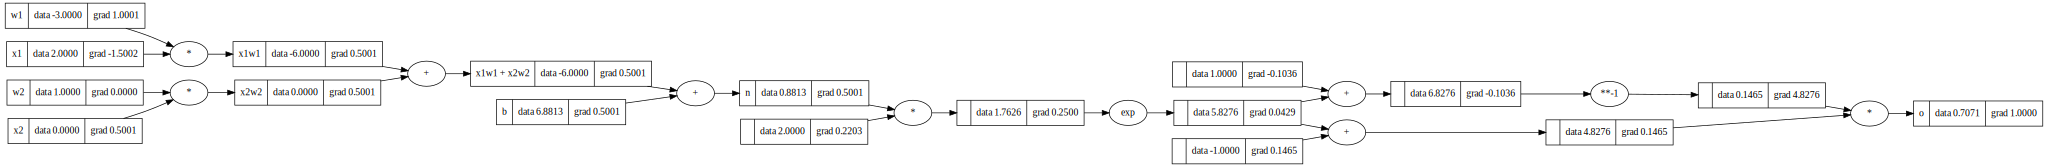

In [ ]:
draw_dot(o)

In [ ]:
o.grad=1.0

#implement topological sort
topo=[]
visited=set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)

build_topo(o)

for node in reversed(topo):
  node._backward()

In [ ]:
#implement topological sort
topo=[]
visited=set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)

build_topo(o)
topo

[Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=6.8813),
 Value(data=0.8813000000000004),
 Value(data=2),
 Value(data=1.7626000000000008),
 Value(data=5.8275693947040725),
 Value(data=-1),
 Value(data=4.8275693947040725),
 Value(data=1),
 Value(data=6.8275693947040725),
 Value(data=0.14646500711888305),
 Value(data=0.7070699857622339)]

In [ ]:
o.grad=1.0

In [ ]:
o._backward()

In [ ]:
n._backward()

In [ ]:
b._backward()

In [ ]:
x1w1x2w2._backward()

In [ ]:
x1w1._backward()

In [ ]:
x2w2._backward()

In [ ]:
x2.grad= w2.data*x2w2.grad
w2.grad= w2.data*x2w2.grad


x1.grad= w1.data*x1w1.grad
w1.grad= w1.data*x1w1.grad

In [ ]:
x1w1.grad=0.5
x2w2.grad=0.5

In [ ]:
x1w1x2w2.grad=0.5
b.grad=0.5

In [ ]:
n.grad=0.5

In [ ]:
o.grad=1.0

In [ ]:
o.data

0.7070699857622339

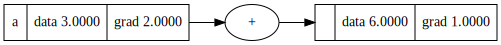

In [ ]:
#bug case
a=Value(3.0, label='a')
b=a+a; label='b'
b.backward()
draw_dot(b) # fwd pass is correct however gradient is not...(b=2a); fixed by +=

In [ ]:
#SIMILAR IMPLEMENTATION USING PYTORCH API

import torch

In [ ]:
x1=torch.Tensor([2.0]).double()    ; x1.requires_grad=True
x2=torch.Tensor([0.0]).double()    ; x2.requires_grad=True
w1=torch.Tensor([-3.0]).double()    ; w1.requires_grad=True
w2=torch.Tensor([1.0]).double()    ; w2.requires_grad=True
b=torch.Tensor([6.8813]).double()    ; b.requires_grad=True

n=x1*w1 + x2*w2 + b
o=torch.tanh(n)

print(o.data.item())
o.backward()

# to verif7y the gradient val;ues with our micrograd
print('x2',x2.grad.item())
print('w2',w2.grad.item())
print('x1',x1.grad.item())
print('w1',w1.grad.item())

0.7070699720278941
x2 0.5000520546564731
w2 0.0
x1 -1.5001561639694192
w1 1.0001041093129461


In [ ]:
torch.Tensor([[1,2,3],[4,5,6]])

tensor([[1., 2., 3.],
        [4., 5., 6.]])

In [ ]:
o

tensor([0.7071], dtype=torch.float64, grad_fn=<TanhBackward0>)

In [ ]:
import random

In [ ]:
#nin => number of inputs

class Neuron:

  def __init__(self,nin):
    self.w=[Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b= Value(random.uniform(-1,1))

  def __call__(self,x):
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out= act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]



class Layer:

  def __init__(self,nin,nout):
    self.neurons=[Neuron(nin) for _ in range(nout)]

  def __call__(self,x):
    outs= [n(x) for n in self.neurons]
    return outs[0] if len(outs)==1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

  def __init__(self,nin,nouts):
    sz= [nin] + nouts
    self.layers= [Layer(sz[i], sz[i+1]) for i in range (len(nouts))]

  def __call__(self,x):
    for layer in self.layers:
      x=layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]


In [ ]:
k=n.parameters()
n.parameters()

[Value(data=0.3021917437470485),
 Value(data=0.6618992332596751),
 Value(data=-0.025366270235985366),
 Value(data=0.3817764807690436),
 Value(data=0.35151204838879835),
 Value(data=-0.3346834190254371),
 Value(data=0.9000590057789644),
 Value(data=-0.6373791771803459),
 Value(data=-0.15115418331802055),
 Value(data=0.40335399474540545),
 Value(data=0.17789545290581654),
 Value(data=0.21085128647088913),
 Value(data=0.8501586665338534),
 Value(data=-0.306847140626074),
 Value(data=0.5047606085690706),
 Value(data=-0.6052558868923077),
 Value(data=-0.5831358116548144),
 Value(data=0.22444724907100322),
 Value(data=0.9552942583207436),
 Value(data=0.8080063447494461),
 Value(data=-0.06741580847213458),
 Value(data=0.08579953838013599),
 Value(data=-0.8771695059140288),
 Value(data=0.6838783693094657),
 Value(data=0.21590769537644872),
 Value(data=0.6490638827938005),
 Value(data=0.5856323465695763),
 Value(data=-0.6683868321975759),
 Value(data=0.6581167316331831),
 Value(data=0.559720694

In [ ]:
len(k)

41

In [ ]:
x=[2.0,3.0,-1.0]
n=MLP(3, [4,4,1])
n(x)

Value(data=0.7120090935446441)

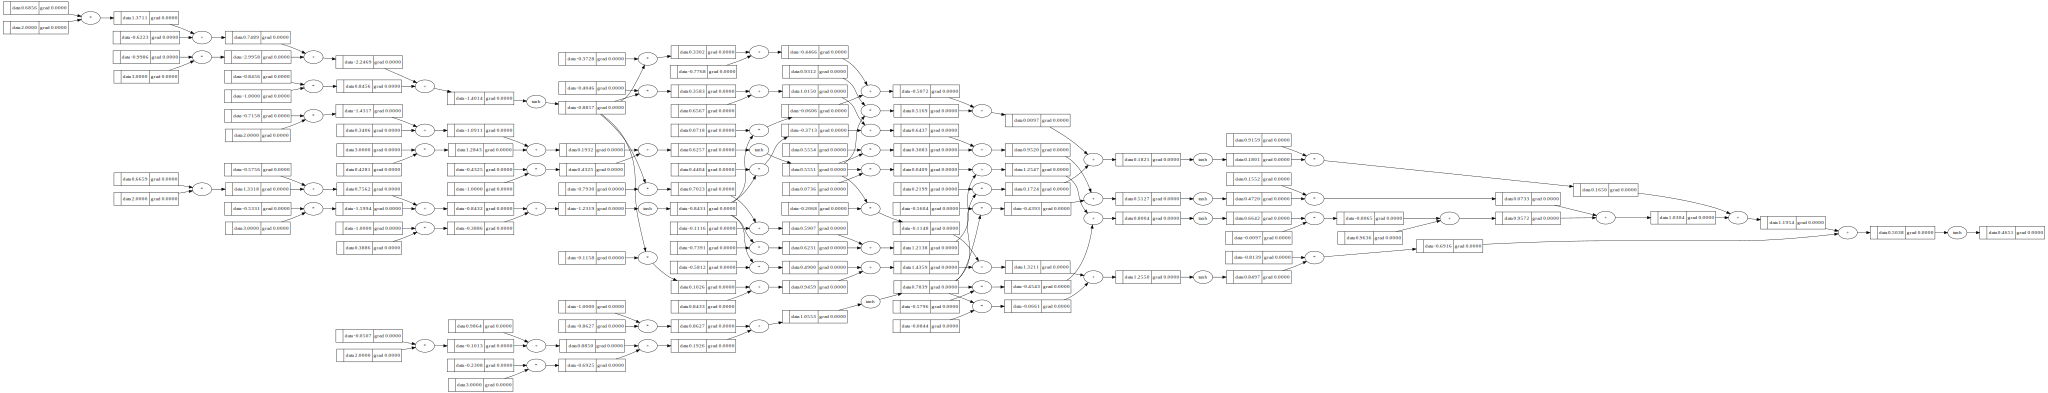

In [ ]:
draw_dot(n(x))

In [ ]:
#tiny dataset
#xs - inputs
xs=[
    [2.0,3.0,-1.0],
    [2.0,3.70,-1.0],
    [2.0,3.0,-1.0],
    [2.0,3.0,-1.0]
]


#ys - desired targets
ys = [1.0,-1.0,-1.0,1.0]

[Value(data=0.7120090935446441),
 Value(data=0.7042975995820533),
 Value(data=0.7120090935446441),
 Value(data=0.7120090935446441)]

In [ ]:
for k in range(20):
  #forward pass
  ypred=[n(x) for x in xs]
  loss = sum(((yout - ygt)**2 for ygt, yout in zip(ys, ypred)), start=Value(0.0))


  #backward pass
  for p in n.parameters:
    p.grad=0.0
  loss.backward()

#updation
  for p in n.parameters():
    p.data+= 0.05*p.grad

  print(k,loss.data)


OverflowError: math range error

In [ ]:
ypred = [n(x) for x in xs]
#implementing mse loss, ygt=ydesired = ys = [1.0,-1.0,-1.0,1.0],each appropriately
loss = sum(((yout - ygt)**2 for ygt, yout in zip(ys, ypred)), start=Value(0.0))
loss

Value(data=6.427259595589447)

In [ ]:
ypred = [n(x) for x in xs]
#implementing mse loss, ygt=ydesired = ys = [1.0,-1.0,-1.0,1.0],each appropriately
loss = sum(((yout - ygt)**2 for ygt, yout in zip(ys, ypred)), start=Value(0.0))
loss

OverflowError: math range error

In [ ]:
loss.backward()

In [ ]:
n.layers[0].neurons[0].w[0].grad

-2355.9835540336026

In [ ]:
n.layers[0].neurons[0].w[0].data

353.67771577016583

In [ ]:
for p in n.parameters():
  p.data+= -0.05*p.grad

In [ ]:
n.layers[0].neurons[0].w[0].data

-117.51899503655473

In [ ]:
ypred

[Value(data=0.8831009048261866),
 Value(data=0.8838717399681879),
 Value(data=0.8831009048261866),
 Value(data=0.8831009048261866)]

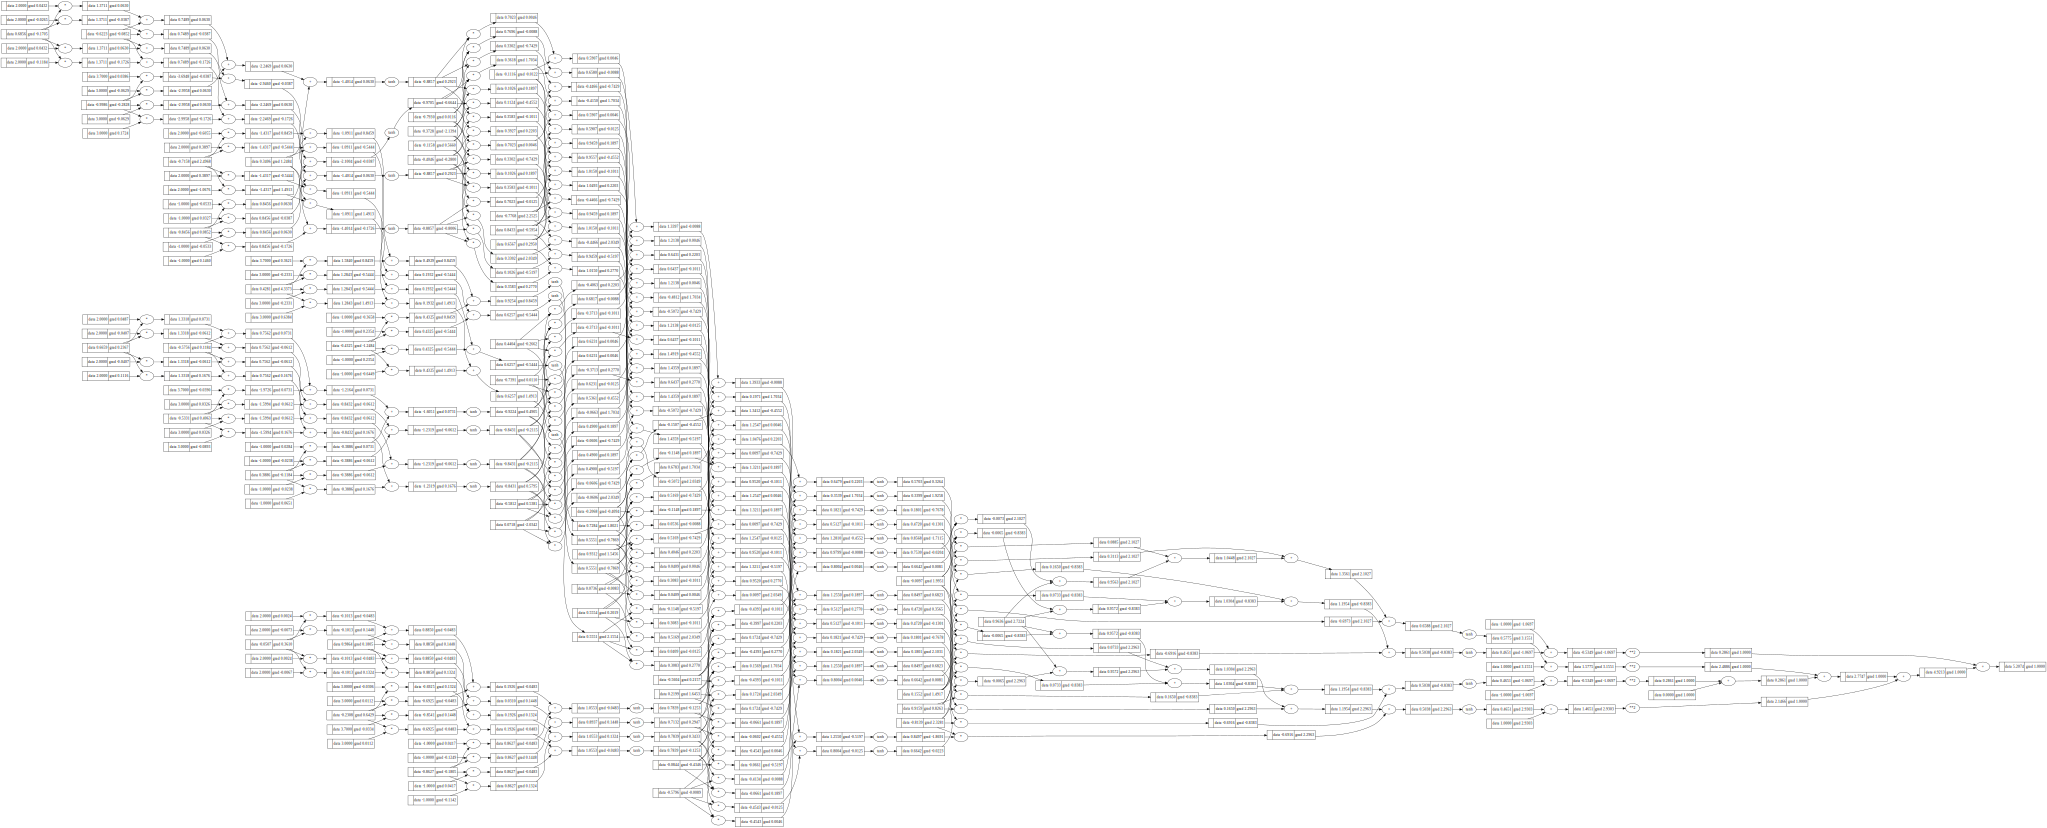

In [ ]:
draw_dot(loss)

In [ ]:
print(type(Value))

<class 'type'>
